In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import re

In [2]:

# Đọc dữ liệu từ file Excel
file_path = 'DATASET HOÀN CHỈNH.xlsx'
sheets = pd.read_excel(file_path, sheet_name=['Customer', 'Product', 'Order', 'Customer Contacts'])


customer_data = sheets['Customer']
product_data = sheets['Product']
order_data = sheets['Order']
customer_contact_data = sheets['Customer Contacts']

# Kết hợp dữ liệu dựa bằng các khóa chính
merged_data = order_data.merge(customer_data, on='Customer ID', how='left') \
                        .merge(product_data, on='Product_Category_ID', how='left') \
                        .merge(customer_contact_data, on='Customer ID', how='left')

In [3]:

# Trích lấy tên đường
merged_data['Street Name'] = merged_data['Address'].apply(lambda x: re.sub(r'^\d+\s+', '', x) if pd.notnull(x) else x)

# Chuyển đổi 'Order Date' thành ngày trong tuần
merged_data['Order Date'] = pd.to_datetime(merged_data['Order Date'])
merged_data['Order Day of Week'] = merged_data['Order Date'].dt.day_name()

In [4]:
# Chọn các cột cần thiết
features = ['City', 'State', 'Product_Category_ID', 'Street Name', 'Order Day of Week']
target = 'Return Reason'

In [5]:
# Điền giá trị trống trong 'Return Reason' bằng "Not Return"
merged_data['Return Reason'] = merged_data['Return Reason'].fillna("Not Return")

In [6]:
# Kiểm tra phân bố lớp của 'Return Reason'
print("Phân bố lớp của 'Return Reason':")
print(merged_data['Return Reason'].value_counts())

Phân bố lớp của 'Return Reason':
Return Reason
Not Return             2702
Received Wrong Item      73
Late Delivery            67
Unsatisfied              67
Defective                59
Quality Issue            44
Name: count, dtype: int64


In [7]:

# Mã hóa các biến sử dụng OneHotEncoder để chuyển đổi dữ liệu phân loại thành ma trận nhị phân.
categorical_features = features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [8]:

# Mô hình cây quyết định
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)


In [9]:
# Tạo pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', dtc)])

In [10]:
# Chia dữ liệu thành đặc trưng và nhãn
X = merged_data[features]
y = merged_data[target]


In [11]:
# Huấn luyện mô hình
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['City', 'State',
                                                   'Product_Category_ID',
                                                   'Street Name',
                                                   'Order Day of Week'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

In [12]:

# Đánh giá hiệu suất mô hình
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X)
print(classification_report(y, y_pred))

                     precision    recall  f1-score   support

          Defective       0.78      0.49      0.60        59
      Late Delivery       0.78      0.48      0.59        67
         Not Return       0.93      0.99      0.96      2702
      Quality Issue       0.91      0.23      0.36        44
Received Wrong Item       1.00      0.27      0.43        73
        Unsatisfied       1.00      0.24      0.39        67

           accuracy                           0.93      3012
          macro avg       0.90      0.45      0.56      3012
       weighted avg       0.93      0.93      0.91      3012



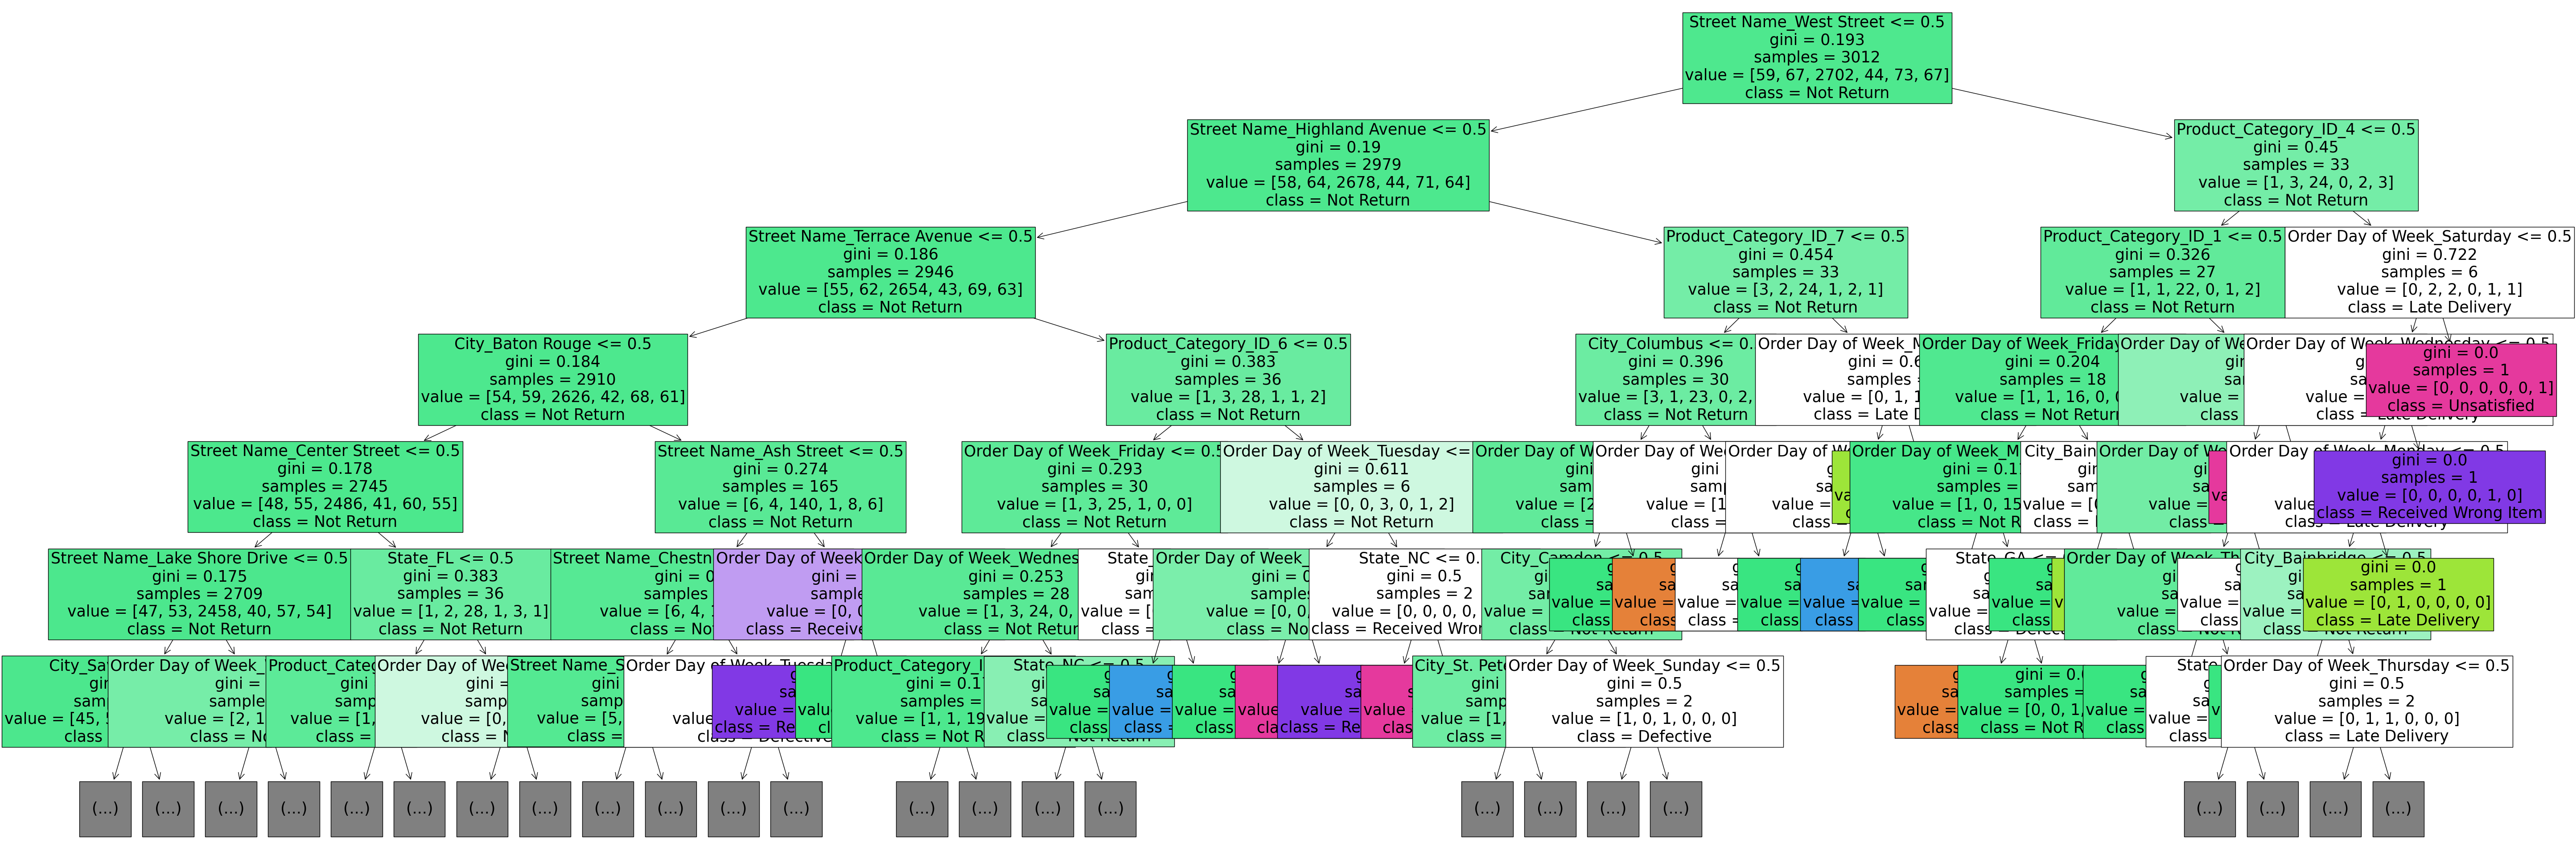

In [35]:
# Vẽ cây quyết định
fig, ax = plt.subplots(figsize=(70, 25))
plot_tree(dtc, max_depth= 6, fontsize=25, 
          feature_names=pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features), 
          class_names=dtc.classes_, filled=True)
#plt.savefig('H4_decision_tree.png')
plt.show()

In [14]:


# Xuất các quy tắc cây quyết định
feature_names_list = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist()
r = export_text(dtc, feature_names=feature_names_list)
print(r)



|--- Street Name_West Street <= 0.50
|   |--- Street Name_Highland Avenue <= 0.50
|   |   |--- Street Name_Terrace Avenue <= 0.50
|   |   |   |--- City_Baton Rouge <= 0.50
|   |   |   |   |--- Street Name_Center Street <= 0.50
|   |   |   |   |   |--- Street Name_Lake Shore Drive <= 0.50
|   |   |   |   |   |   |--- City_Savannah <= 0.50
|   |   |   |   |   |   |   |--- Street Name_Jefferson Street <= 0.50
|   |   |   |   |   |   |   |   |--- Street Name_Smith Street <= 0.50
|   |   |   |   |   |   |   |   |   |--- Street Name_Hillcrest Avenue <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Street Name_Willow Street <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- Street Name_Willow Street >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- Street Name_Hillcrest Avenue >  0.50
|   |   |   |   |   |   |   |   |   |   |--- Order 

In [17]:
# Dự đoán
new_data = pd.DataFrame({
    'City': ['Covington'],
    'State': ['GA'],
    'Product_Category_ID': [6],
    'Street Name': ['River Road'],
    'Order Day of Week': ['Friday']
})


new_data_transformed = pipeline.named_steps['preprocessor'].transform(new_data)

# Dự đoán lý do trả hàng cho dữ liệu mới
predicted_reason = pipeline.predict(new_data)

print(f"Dự đoán lý do trả hàng cho dữ liệu mới là: {predicted_reason[0]}")


Dự đoán lý do trả hàng cho dữ liệu mới là: Not Return
